In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
#Import Dataset
dataset = pd.read_csv('TrainData.csv.gz', compression ='gzip')
dataset.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,activity_count,user_session_count,date,weekday
0,2019-12-05 14:47:30+00:00,1,1005100,samsung,130.35,582466509,7af4eee5-a302-409b-9285-d32f17fe127d,10.0,2,5,3
1,2020-01-26 03:11:20+00:00,1,1005266,xiaomi,124.80,535107348,03018836-e470-4301-a3a7-e5e8ceecaf6e,15.0,8,26,6
2,2020-01-24 07:13:03+00:00,1,1201567,apple,384.26,602793405,1bcf63a1-b495-4aff-90be-7aefc2100a13,5.0,6,24,4
3,2019-12-04 03:00:48+00:00,1,1701392,acer,135.14,581740838,83089517-0691-4ece-9341-0ae697fdcd91,5.0,0,4,2
4,2020-01-16 08:58:58+00:00,1,1005203,xiaomi,102.18,601849665,dbb1104e-8131-4542-8b0e-f9616af633d2,2.0,3,16,3


In [3]:
# Basic overview of all data points and categories. Further information is available in DataDescription.txt
dataset.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3544820 entries, 0 to 3544819
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   event_time          3544820 non-null  object 
 1   event_type          3544820 non-null  int64  
 2   product_id          3544820 non-null  int64  
 3   brand               3544820 non-null  object 
 4   price               3544820 non-null  float64
 5   user_id             3544820 non-null  int64  
 6   user_session        3544785 non-null  object 
 7   activity_count      3544785 non-null  float64
 8   user_session_count  3544820 non-null  int64  
 9   date                3544820 non-null  int64  
 10  weekday             3544820 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 297.5+ MB


In [4]:
#Clean dataset by removing NaN values in activity_count and user_session_count
dataset.dropna(inplace = True)

#### Variable of interest: event_type
event_type is a binary categorical variable with the value of 1 and 2 (numeric) indicating whether items in cart remains in cart (event_type == 1) or is purchased eventually (event_type == 2)

##### Typical steps to follow while building a supervised machine learning model on a given dataset:
    o Partition the labeled dataset into two random portions – 75% to Train the model and 25% to Test the model.
    o Fit the desired supervised machine learning model on the Train set to predict response using the predictors.
    o Predict response using the predictors on the Test set using the machine learning model fit on the Train data.
    o Check the Prediction Accuracy of the model on both the Train and the Test sets using the “Confusion Matrix”

# XGBoost model

In order to improve the accuracy of our classification, we use ensemble modelling methods. This means that we will divide the big data modelling tasks into smaller models and aggregate the predicted results based on this to decide the final predicted result. 

In order to achieve this, there are 2 key method of ensemble modelling methods: Boosting and Bagging.

After realize the Random Forest model (Bagging) offer no significant improvement for our classification, we turn to Boosting model with the model of choice being **XGBoost**

Unlike Random Forest which build a forest of parallel decision tree, the idea behind Boosting is to build a sequence of small decision trees from the whole data sample, each learn from the mistakes of the previous trees to minimize error (biases) and improve accuracy of the model. This approach is similar to Deep Neural Network (DNN) in the way it assign weight to each weaker predictors. However, it is less costly in term of computational power when it comes to supervised learning (tabular labeled data) and thus is often superior.\


There are a few popular boosting model which includes: AdaBoost, GradientBoost and XGBoost.
We choose XGBoost because of 3 advantages it has over it counter-parts:
1. Regularization: XGBoost includes additional regularization techniques, such as L1 and L2 regularization, **to prevent overfitting.** Gradient Boosting and AdaBoost do not include these regularization techniques.
2. Speed: XGBoost is generally faster than traditional Gradient Boosting, as it includes several optimization techniques, such as an approximate greedy algorithm for tree splitting and parallel processing. **This is important as practically, we will have to train on very large set of data in the future.**
3. Multi-Class Classification: XGBoost can handle multi-class classification problems natively, whereas Gradient Boosting and AdaBoost require a One-vs-All approach to solve multi-class problems. **While our current model does not require this, it is our aim to apply this model to a 3-class problem of predictive classification for view, cart and purchase event.**

Hence, we will build a XGBoost model to improve the accuracy of our prediction over 60%


In [18]:
# Import essential models and functions from sklearn and xgboost libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb



In [6]:
# Generate a one-hot encoding for brands as it is a nominal categorical variable
d = dataset.groupby('brand').size()
d.sort_values( ascending = False, inplace=True)
brand_code = {brand_name:x for x,brand_name in enumerate(d.index) }
dataset['brand'] = dataset['brand'].map(brand_code)
dataset.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,activity_count,user_session_count,date,weekday
0,2019-12-05 14:47:30+00:00,1,1005100,0,130.35,582466509,7af4eee5-a302-409b-9285-d32f17fe127d,10.0,2,5,3
1,2020-01-26 03:11:20+00:00,1,1005266,2,124.80,535107348,03018836-e470-4301-a3a7-e5e8ceecaf6e,15.0,8,26,6
2,2020-01-24 07:13:03+00:00,1,1201567,1,384.26,602793405,1bcf63a1-b495-4aff-90be-7aefc2100a13,5.0,6,24,4
3,2019-12-04 03:00:48+00:00,1,1701392,10,135.14,581740838,83089517-0691-4ece-9341-0ae697fdcd91,5.0,0,4,2
4,2020-01-16 08:58:58+00:00,1,1005203,2,102.18,601849665,dbb1104e-8131-4542-8b0e-f9616af633d2,2.0,3,16,3


In [13]:
#split dataset in features and target variable
predictor_cols = ['price', 'brand', 'activity_count', 'user_session_count','weekday','date']
predictors = dataset[predictor_cols] # Features
response = dataset.event_type.map({1:0,2:1}) # Target variable, map to 0 and 1 for XGBoost model to run

In [41]:
def XGBoost (response, predictors): 
    #Step 1: Partition data into train and test dataset.
    X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size = 0.25) #default 75% train, 25% test split
              
    #Step 2:Initialize and train the Random Forest classifier
    model = xgb.XGBClassifier(learning_rate=0.1,n_estimators =1000)     #Create the XGBoost Classifier 
                                                                        #object with learning_rate 0.1 and use 1000 tree estimators
    model.fit(X_train, y_train)                    # train the XGBoost Classifier

    #Step 3: Predict Response corresponding to Predictors
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

    #Step 4: Check the Goodness of fit (GOF)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", accuracy_score(y_train, y_train_pred))
    print()
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", accuracy_score(y_test, y_test_pred))
    print()

    TN = confusion_matrix(y_test,y_test_pred)[0][0]
    FN = confusion_matrix(y_test,y_test_pred)[1][0]
    TP = confusion_matrix(y_test,y_test_pred)[1][1]
    FP = confusion_matrix(y_test,y_test_pred)[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print ("True Positive Rate: ", TPR)

    '''# Specificity or true negative rate
    TNR = TN/(TN+FP)
    print ("True Negative Rate: ", TNR)'''

    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print ("False Positive Rate: ", FPR)

    '''# False negative rate
    FNR = FN/(TP+FN)
    print ("False Negative Rate: ", FNR)'''


    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print ("Overall accuracy: ", ACC)
    print()
    print()

    return model, ACC

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6427705233003383

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6370107323766612

True Positive Rate:  0.6128886086922258
False Positive Rate:  0.34258840779534006
Overall accuracy:  0.6370107323766612




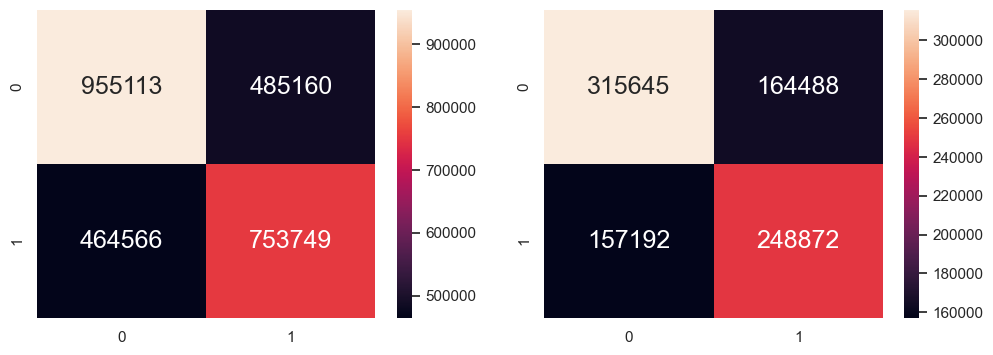

In [42]:
model, acc = XGBoost (response, predictors)

The accuracy does improve as compared to the random forrest model **(63.70% compared with 63.04% from random forrest model)**, although not by much. However, the **speed of genrating the model improve significantly**. This is important if we want to train and improve the model in real time to predict customers' behaviour and customize their experience on our online shopping platform.

### Insights from Model: Feature(Predictor) Importance

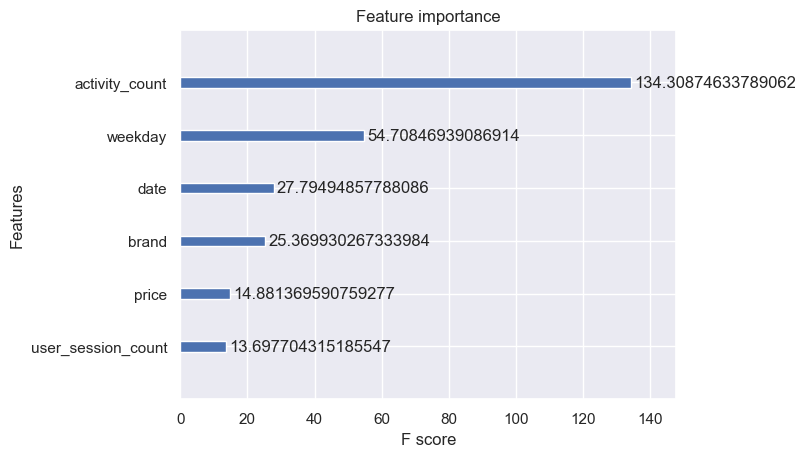

In [38]:
xgb.plot_importance(model, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()

From this model, it is clear that **activity count is the best predictor** for a purchase of an item in cart. This makes sense as the more time users spend on the platform indicates that they are likely to buy something eventually, especially so if the item is already in cart.

Interestingly however, **day of the week is also a very good predictor** for the purchase of a product in cart. While there seems to be no logical connection between these 2 variables without further context of the online platform format, layout and so one, it seems like Thursday and Friday are the worse performing days for the platform. Hence, we can suggest putting out promotions on Monday as it is the best performing day of the week.

Finally, brand, price and user's history (familiarity with the platform) is surprisingly not a good predictors. While they still contribute to our model, it seems like once the product is put in cart, brand, prices and user familiarity are no longer factors that determine whether users will go through with the purchase. Once again, this makes sense as these 3 factors are already considered by the users before adding them to cart, making them a less important predictors.

# Final Comments on Project

As our final product is the XGBoost model is completed, we want to reflect on our project outcome and the learning points we achieved during this process.

### Project Outcome, Limitation and Future Direction
First, we are satisfied with the project as not only does it enhance our data science skills and knowledge, it helps us gain a better understanding of the online shopping industry and specific metrics we can use to measure and predict customers' behaviours such as: .....

Second, there are limitations to our project that are caused by a) our lacking in knowledge and skills (those that will require a steep learning curve) and b) our lacking in time and computational resources. These includes:
1. Expansion of data size: While there are a total of 5 months of data available, jupyter notebook memory are not able to handle  the size of data available and thus we are unable to make our model even more accurate with more data to train on.

2. View-to-cart model: As mentioned in the DataMining_and_Visualization workbook, we would like to build a model to predict the probability of a user moving an item to cart. This problem is more interesting as it will have an imbalance number of data. Moreover, it is **more practical** as **the majority of users stop at viewing and not putting the product in cart**. Hence to boost revenue, the best way is to convince users to move beyond viewing and actually putting items in cart for considerations.

3. Features engineering: There are other features we would like to consider and engineer to be more relevant to the problem at hand such as promotion/sales, bounce rate, etc. that can improve our model accuracy. However, given the limited data and time, we fail to incorporate them.

4. Tuning Hyperparameters: XGBoost library provide us with cross-validation functions designed to help us optimize the hyperparameters of the model to best fit our data without risking overfitting. However, this requires a lot of time to learn and experiment that we fail to do.

Third, in the future, we hope to incorporate and address the above-mentioned limitation to create a more robust model and gain a deeper understanding of the online shopping problem. The goal is to build a recommendation model that can tailor our business strategy to the user's profile.

### Learning points and Learning opportunities

1. Manage memory: While dealing with dataframes of large size, we learned to use inplace=True argument to modify the dataframes directly whenever possible rather than creating a copy of the dataframe. We also learn to delete variables and dataframes using del to free up memory space for further analysis.

2. Expansion of data: dask is a library that support the scalling of pandas dataframe using queue management and cloud computing. However, the learning curve for dask is very steep. We hope to explore more of it in the future once we are proficient in pandas

3. XGBoost: We learned about XGBoost, one of the best machine learning model for supervised learning on simple data format such as tabular(categorical and numeric) data. However, there are a lot more to explore in this Boosting method, especially in optimizing and tuning hyperparameters.